In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
companies = pd.read_csv('../data/input/companies.csv', encoding='palmos')
rounds2 = pd.read_csv('../data/input/rounds2.csv', encoding='palmos')

In [3]:
companies.shape
companies.head()

rounds2.shape
rounds2.head()

(66368, 10)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/Organization/-The-One-Of-Them-Inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
3,/Organization/0-6-Com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007
4,/Organization/004-Technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010


(114949, 6)

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0
3,/ORGANIZATION/-THE-ONE-OF-THEM-INC-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0


In [4]:
# checking proportion of null values
companies.isnull().sum() / len(companies)
rounds2.isnull().sum() / len(rounds2)

permalink        0.000000
name             0.000015
homepage_url     0.076211
category_list    0.047432
status           0.000000
country_code     0.104840
state_code       0.128782
region           0.120992
city             0.120962
founded_at       0.229342
dtype: float64

company_permalink          0.000000
funding_round_permalink    0.000000
funding_round_type         0.000000
funding_round_code         0.729097
funded_at                  0.000000
raised_amount_usd          0.173903
dtype: float64

The variables of concern for us are `category_list`, `country_code` and `raised_amount_usd`. The other columns missing values are not used in the below analysis and hence are of no concern for us.
- `category_list` has less than 5% missing, which can be ignored. The missing values have sector mapping in mapping file, so we are going to leave the missing values as is.
- For `country_code`, we can fill a new value as `Missing` country code.
- For `raised_amount_usd`, we have three options:
    - Drop these rows - difficult to justify, since we would end up dropping 17% of the data.
    - Fill with 0 - Decent option
    - Fill with median - Might inflate the sum values
    - Leave as is - Decent option
- Pandas aggregation ignores null values. So, we are going to leave the `raised_amount_usd` as is.

In [5]:
# checking missing raised_amount_usd by funding_round_type
rounds2.groupby('funding_round_type')['raised_amount_usd'].agg(lambda x: x.isnull().sum() / len(x))

funding_round_type
angel                    0.202494
convertible_note         0.203632
debt_financing           0.030892
equity_crowdfunding      0.622966
grant                    0.034545
non_equity_assistance    0.617801
post_ipo_debt            0.000000
post_ipo_equity          0.015674
private_equity           0.152735
product_crowdfunding     0.058537
secondary_market         0.684211
seed                     0.226740
undisclosed              0.676945
venture                  0.094893
Name: raised_amount_usd, dtype: float64

### Checkpoint 1: Data Cleaning 1

In [6]:
# fill missing values
companies['country_code'].fillna('MISSING', inplace=True)

In [7]:
# # Table 1.1 - 1
# # How many unique companies are present in rounds2?
# rounds2['company'] = rounds2['company_permalink'].apply(lambda x: str(x).lower().replace('/organization/', ''))
# rounds2['company'].unique()
# rounds2['company'].nunique()

In [8]:
# Table 1.1 - 1
# How many unique companies are present in rounds2?
len(rounds2['company_permalink'])
rounds2['company_permalink'].nunique()
rounds2['company_permalink'].str.lower().nunique()
rounds2['funding_round_permalink'].nunique()

114949

90247

66368

114949

In [9]:
# Table 1.1 - 2
# How many unique companies are present in the companies file?
len(companies['permalink'])
companies['permalink'].nunique()
companies['permalink'].str.lower().nunique()

# companies['name'].isnull().sum()
# companies['name'].nunique()
# companies['name'].str.lower().nunique()

66368

66368

66368

In [10]:
# Table 1.1 - 4
# Are there any companies in the rounds2 file which are not  present in companies ? Answer Y/N.
set(rounds2['company_permalink'].str.lower()).difference(set(companies['permalink'].str.lower()))
# set(companies['permalink'].str.lower()).difference(set(rounds2['company_permalink'].str.lower()))

set()

In [11]:
# df = companies[['name', 'permalink']].copy()
# df['permalink'] = df['permalink'].str.lower()
# df = df.groupby('name')['permalink'].agg(list)
# df

In [12]:
# Table 1.1 - 5
# Merge the two data frames so that all  variables (columns)  in the companies frame 
# are added to the rounds2 data frame. Name the merged frame master_frame. 
# How many observations are present in master_frame ?
rounds2['company_permalink_lower'] = rounds2['company_permalink'].str.lower()
companies['permalink_lower'] = companies['permalink'].str.lower()
master_frame = rounds2.merge(companies, 
                             left_on='company_permalink_lower', 
                             right_on='permalink_lower',
                             how='left')
master_frame.drop(['permalink', 'company_permalink'], axis=1, inplace=True)
master_frame.drop_duplicates(inplace=True)
master_frame.shape

(114949, 16)

In [13]:
master_frame.head()

,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,company_permalink_lower,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,permalink_lower
0,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame
1,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter
2,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter
3,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,MISSING,NaN,NaN,NaN,NaN,/organization/-the-one-of-them-inc-
4,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007,/organization/0-6-com


### Checkpoint 2: Funding Type Analysis

In [14]:
# Table 2.1
master_frame['funding_round_type'].unique()
# filtering data to ['venture', 'angel', 'seed', 'private_equity']
rep_funding = master_frame.loc[master_frame['funding_round_type'].isin(['venture', 'angel', 'seed', 'private_equity'])].copy()
rep_funding.head()
rep_funding.shape

array(['venture', 'seed', 'undisclosed', 'equity_crowdfunding',
       'convertible_note', 'private_equity', 'debt_financing', 'angel',
       'grant', 'secondary_market', 'post_ipo_equity', 'post_ipo_debt',
       'product_crowdfunding', 'non_equity_assistance'], dtype=object)

,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,company_permalink_lower,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,permalink_lower
0,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame
1,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter
2,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter
3,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,MISSING,NaN,NaN,NaN,NaN,/organization/-the-one-of-them-inc-
4,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007,/organization/0-6-com


(94397, 16)

In [15]:
rep_funding.raised_amount_usd.isnull().sum()
rep_funding.funding_round_type.isnull().sum()

13770

0

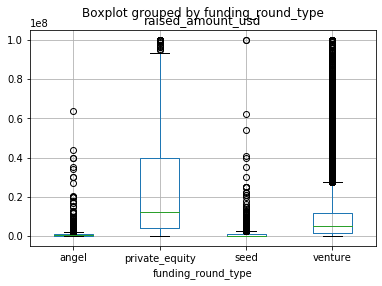

In [16]:
# checking boxplot per group
rep_funding_filt = rep_funding.loc[rep_funding['raised_amount_usd'] <= 1e8]
rep_funding_filt.fillna(0.0).boxplot(column='raised_amount_usd', by='funding_round_type')

In [17]:
rep_funding.groupby('funding_round_type').describe()

raised_amount_usd                                   \
                               count          mean           std  min   
funding_round_type                                                      
angel                         4860.0  9.586945e+05  7.404397e+06  0.0   
private_equity                1936.0  7.330859e+07  1.981135e+08  0.0   
seed                         23603.0  7.198180e+05  2.221733e+06  0.0   
venture                      50228.0  1.174895e+07  8.635207e+07  0.0   

                                                                      
                           25%         50%         75%           max  
funding_round_type                                                    
angel                150000.00    400000.0   1000000.0  4.945120e+08  
private_equity      5000000.00  20000000.0  75000000.0  4.745460e+09  
seed                  55000.00    275000.0   1000000.0  2.000000e+08  
venture             1600901.75   5000000.0  12000000.0  1.760000e+10

In [18]:
# rep_funding.loc[rep_funding['raised_amount_usd'] >= 1e10]

In [19]:
# Table 2.1
# Representative funding amount of venture type
# Representative funding amount of angel type
# Representative funding amount of seed type
# Representative funding amount of private equity type
# taking median as Representative funding
rep_funding.groupby('funding_round_type')['raised_amount_usd'].agg('median')

funding_round_type
angel               400000.0
private_equity    20000000.0
seed                275000.0
venture            5000000.0
Name: raised_amount_usd, dtype: float64

### Checkpoint 3: Country Analysis

In [20]:
# filtering to venture funding type
country_data = rep_funding.loc[rep_funding['funding_round_type']=='venture'].copy()
country_data.shape
country_data.head()

(55494, 16)

,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,company_permalink_lower,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,permalink_lower
0,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame
1,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter
3,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,MISSING,NaN,NaN,NaN,NaN,/organization/-the-one-of-them-inc-
4,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007,/organization/0-6-com
5,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,24-07-2014,NaN,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010,/organization/004-technologies


In [21]:
country_data.raised_amount_usd.isnull().sum()
country_data.country_code.isnull().sum()
country_data.city.isnull().sum()

5266

0

3554

In [22]:
# Spark Funds wants to see the top nine countries which have received the highest total funding
# (across ALL sectors for the chosen investment type)
# For the chosen investment type, make a data frame named top9 with the top nine countries 
# (based on the total investment amount each country has received)
top9 = country_data.groupby('country_code')['raised_amount_usd'].sum().sort_values(ascending=False).head(9)
top9 = pd.DataFrame(top9).reset_index()
top9

,country_code,raised_amount_usd
0,USA,4.225108e+11
1,CHN,3.983542e+10
2,MISSING,2.550611e+10
3,GBR,2.024563e+10
4,IND,1.439186e+10
5,CAN,9.583332e+09
6,FRA,7.259537e+09
7,ISR,6.907515e+09
8,DEU,6.346960e+09


In [23]:
# Identify the top three English-speaking countries in the data frame top9.
top3_english_country = ['USA', 'GBR', 'IND']
top3_english_country

['USA', 'GBR', 'IND']

### Checkpoint 4: Sector Analysis 1

In [24]:
# filter to top3 english speaking countries for venture funding_round_type
sector_analysis = country_data.loc[country_data['country_code'].isin(top3_english_country)].copy()
sector_analysis.shape
sector_analysis.head()

(41667, 16)

,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,company_permalink_lower,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,permalink_lower
0,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame
1,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter
5,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,24-07-2014,NaN,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010,/organization/004-technologies
10,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,09-11-2015,20000000.0,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,/organization/0xdata
11,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,NaN,03-01-2013,1700000.0,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,/organization/0xdata


In [25]:
# Use the mapping file 'mapping.csv' to map each primary sector to one of the eight main sectors 
# (Note that ‘Others’ is also considered one of the main sectors)
mapping = pd.read_csv('../data/input/mapping.csv')
mapping.rename(columns={'category_list': 'category'}, inplace=True)
mapping['main_sector'] = mapping.drop('category', axis=1).idxmax(axis=1)
mapping.head()

,category,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising",main_sector
0,NaN,0,1,0,0,0,0,0,0,0,Blanks
1,3D,0,0,0,0,0,1,0,0,0,Manufacturing
2,3D Printing,0,0,0,0,0,1,0,0,0,Manufacturing
3,3D Technology,0,0,0,0,0,1,0,0,0,Manufacturing
4,Accounting,0,0,0,0,0,0,0,0,1,"Social, Finance, Analytics, Advertising"


In [26]:
# mapping.columns

In [27]:
# mapping.melt(id_vars=['category_list'], value_vars=['Automotive & Sports', 'Blanks',
#        'Cleantech / Semiconductors', 'Entertainment', 'Health',
#        'Manufacturing', 'News, Search and Messaging', 'Others',
#        'Social, Finance, Analytics, Advertising'])

In [28]:
# check nan
sector_analysis['category_list'].isnull().sum()

384

In [29]:
# Extract the primary sector of each category list from the category_list column
# extract first value as primary_sector if category_list is notnull

sector_analysis['primary_sector'] = sector_analysis['category_list'].apply(
    lambda x: str(x).split('|')[0] if pd.notnull(x) else x)

In [30]:
# sorted(sector_analysis['primary_sector'].unique().tolist())

In [31]:
# merge with mapping file to get main_sector
sector_analysis = sector_analysis.merge(mapping[['category', 'main_sector']], 
                                        left_on='primary_sector', right_on='category', how='left')

In [32]:
sector_analysis.head()

,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,company_permalink_lower,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,permalink_lower,primary_sector,category,main_sector
0,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,Media,Media,Entertainment
1,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter,Application Platforms,Application Platforms,"News, Search and Messaging"
2,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,24-07-2014,NaN,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010,/organization/004-technologies,Software,Software,Others
3,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,09-11-2015,20000000.0,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,/organization/0xdata,Analytics,NaN,NaN
4,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,NaN,03-01-2013,1700000.0,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,/organization/0xdata,Analytics,NaN,NaN


### Checkpoint 5: Sector Analysis 2

In [33]:
# filter by funding amount
sector_analysis_fund = sector_analysis.loc[(sector_analysis['raised_amount_usd'] >= 5000000) & 
                                           (sector_analysis['raised_amount_usd'] <= 15000000)]

In [34]:
# filter by country
sector_analysis_usa = sector_analysis_fund.loc[sector_analysis_fund['country_code']=='USA'].copy()
sector_analysis_gbr = sector_analysis_fund.loc[sector_analysis_fund['country_code']=='GBR'].copy()
sector_analysis_ind = sector_analysis_fund.loc[sector_analysis_fund['country_code']=='IND'].copy()

In [35]:
# calculate the total number of investments and the total amount of investments 
# in each main sector for each of the three countries
sector_analysis_usa = sector_analysis_usa.groupby(['country_code', 'main_sector']).agg(
    {'funding_round_permalink': 'count', 'raised_amount_usd': 'sum'})
sector_analysis_gbr = sector_analysis_gbr.groupby(['country_code', 'main_sector']).agg(
    {'funding_round_permalink': 'count', 'raised_amount_usd': 'sum'})
sector_analysis_ind = sector_analysis_ind.groupby(['country_code', 'main_sector']).agg(
    {'funding_round_permalink': 'count', 'raised_amount_usd': 'sum'})

In [36]:
sector_analysis_usa

funding_round_permalink  \
country_code main_sector                                                        
USA          Automotive & Sports                                          167   
             Blanks                                                        86   
             Cleantech / Semiconductors                                  2297   
             Entertainment                                                580   
             Health                                                       908   
             Manufacturing                                                799   
             News, Search and Messaging                                  1563   
             Others                                                      2923   
             Social, Finance, Analytics, Advertising                     1912   

                                                      raised_amount_usd  
country_code main_sector                                                 
USA          Automotive & Sports                           1.454104e+09  
             Blanks                                        7.647633e+08  
             Cleantech / Semiconductors                    2.118100e+10  
             Entertainment                                 5.000213e+09  
             Health                                        8.200859e+09  
             Manufacturing                                 7.258553e+09  
             News, Search and Messaging                    1.379682e+10  
             Others                                        2.608928e+10  
             Social, Finance, Analytics, Advertising       1.668070e+10

In [37]:
sector_analysis_gbr

funding_round_permalink  \
country_code main_sector                                                        
GBR          Automotive & Sports                                           16   
             Blanks                                                         7   
             Cleantech / Semiconductors                                   127   
             Entertainment                                                 54   
             Health                                                        24   
             Manufacturing                                                 42   
             News, Search and Messaging                                    73   
             Others                                                       143   
             Social, Finance, Analytics, Advertising                       98   

                                                      raised_amount_usd  
country_code main_sector                                                 
GBR          Automotive & Sports                           1.670516e+08  
             Blanks                                        5.776485e+07  
             Cleantech / Semiconductors                    1.136905e+09  
             Entertainment                                 4.615111e+08  
             Health                                        2.145375e+08  
             Manufacturing                                 3.619403e+08  
             News, Search and Messaging                    6.157462e+08  
             Others                                        1.249124e+09  
             Social, Finance, Analytics, Advertising       8.218884e+08

In [38]:
sector_analysis_ind

funding_round_permalink  \
country_code main_sector                                                        
IND          Automotive & Sports                                           13   
             Blanks                                                         2   
             Cleantech / Semiconductors                                    20   
             Entertainment                                                 33   
             Health                                                        19   
             Manufacturing                                                 21   
             News, Search and Messaging                                    52   
             Others                                                       109   
             Social, Finance, Analytics, Advertising                       32   

                                                      raised_amount_usd  
country_code main_sector                                                 
IND          Automotive & Sports                           1.369000e+08  
             Blanks                                        2.700000e+07  
             Cleantech / Semiconductors                    1.653800e+08  
             Entertainment                                 2.808300e+08  
             Health                                        1.677400e+08  
             Manufacturing                                 2.009000e+08  
             News, Search and Messaging                    4.338345e+08  
             Others                                        1.007410e+09  
             Social, Finance, Analytics, Advertising       2.905435e+08

In [39]:
# Total number of Investments (count)
sector_analysis_fund.groupby(['country_code']).agg({'funding_round_permalink': 'count'})

,funding_round_permalink
country_code,
GBR,628
IND,330
USA,12150


In [40]:
# Total amount of investment (USD)
sector_analysis_fund.groupby(['country_code']).agg({'raised_amount_usd': 'sum'})

,raised_amount_usd
country_code,
GBR,5.436844e+09
IND,2.976544e+09
USA,1.085313e+11


In [41]:
# Top Sector name (no. of investment-wise) - USA
sector_analysis_usa.sort_values('funding_round_permalink', ascending=False)

funding_round_permalink  \
country_code main_sector                                                        
USA          Others                                                      2923   
             Cleantech / Semiconductors                                  2297   
             Social, Finance, Analytics, Advertising                     1912   
             News, Search and Messaging                                  1563   
             Health                                                       908   
             Manufacturing                                                799   
             Entertainment                                                580   
             Automotive & Sports                                          167   
             Blanks                                                        86   

                                                      raised_amount_usd  
country_code main_sector                                                 
USA          Others                                        2.608928e+10  
             Cleantech / Semiconductors                    2.118100e+10  
             Social, Finance, Analytics, Advertising       1.668070e+10  
             News, Search and Messaging                    1.379682e+10  
             Health                                        8.200859e+09  
             Manufacturing                                 7.258553e+09  
             Entertainment                                 5.000213e+09  
             Automotive & Sports                           1.454104e+09  
             Blanks                                        7.647633e+08

In [42]:
# Top Sector name (no. of investment-wise) - GBR
sector_analysis_gbr.sort_values('funding_round_permalink', ascending=False)

funding_round_permalink  \
country_code main_sector                                                        
GBR          Others                                                       143   
             Cleantech / Semiconductors                                   127   
             Social, Finance, Analytics, Advertising                       98   
             News, Search and Messaging                                    73   
             Entertainment                                                 54   
             Manufacturing                                                 42   
             Health                                                        24   
             Automotive & Sports                                           16   
             Blanks                                                         7   

                                                      raised_amount_usd  
country_code main_sector                                                 
GBR          Others                                        1.249124e+09  
             Cleantech / Semiconductors                    1.136905e+09  
             Social, Finance, Analytics, Advertising       8.218884e+08  
             News, Search and Messaging                    6.157462e+08  
             Entertainment                                 4.615111e+08  
             Manufacturing                                 3.619403e+08  
             Health                                        2.145375e+08  
             Automotive & Sports                           1.670516e+08  
             Blanks                                        5.776485e+07

In [43]:
# Top Sector name (no. of investment-wise) - IND
sector_analysis_ind.sort_values('funding_round_permalink', ascending=False)

funding_round_permalink  \
country_code main_sector                                                        
IND          Others                                                       109   
             News, Search and Messaging                                    52   
             Entertainment                                                 33   
             Social, Finance, Analytics, Advertising                       32   
             Manufacturing                                                 21   
             Cleantech / Semiconductors                                    20   
             Health                                                        19   
             Automotive & Sports                                           13   
             Blanks                                                         2   

                                                      raised_amount_usd  
country_code main_sector                                                 
IND          Others                                        1.007410e+09  
             News, Search and Messaging                    4.338345e+08  
             Entertainment                                 2.808300e+08  
             Social, Finance, Analytics, Advertising       2.905435e+08  
             Manufacturing                                 2.009000e+08  
             Cleantech / Semiconductors                    1.653800e+08  
             Health                                        1.677400e+08  
             Automotive & Sports                           1.369000e+08  
             Blanks                                        2.700000e+07

In [44]:
# For point 3 (top sector count-wise), which company received the highest investment?
# we are ignoring Others sector
sector_analysis_fund_topsector_usa = sector_analysis_fund.loc[
    (sector_analysis_fund['main_sector']=='Cleantech / Semiconductors') &
    (sector_analysis_fund['country_code']=='USA')]
sector_analysis_fund_topsector_gbr = sector_analysis_fund.loc[
    (sector_analysis_fund['main_sector']=='Cleantech / Semiconductors') & 
    (sector_analysis_fund['country_code']=='GBR')]
sector_analysis_fund_topsector_ind = sector_analysis_fund.loc[
    (sector_analysis_fund['main_sector']=='News, Search and Messaging') & 
    (sector_analysis_fund['country_code']=='IND')]

In [45]:
sector_analysis_fund_topsector_usa.groupby(['country_code', 'main_sector', 'company_permalink_lower']).agg(
    {'raised_amount_usd': 'sum'}).idxmax().values
sector_analysis_fund_topsector_gbr.groupby(['country_code', 'main_sector', 'company_permalink_lower']).agg(
    {'raised_amount_usd': 'sum'}).idxmax().values
sector_analysis_fund_topsector_ind.groupby(['country_code', 'main_sector', 'company_permalink_lower']).agg(
    {'raised_amount_usd': 'sum'}).idxmax().values

array([('USA', 'Cleantech / Semiconductors', '/organization/biodesix')],
      dtype=object)

array([('GBR', 'Cleantech / Semiconductors', '/organization/eusa-pharma')],
      dtype=object)

array([('IND', 'News, Search and Messaging', '/organization/gupshup-technology-india-pvt-ltd')],
      dtype=object)

In [46]:
# For point 4 (second best sector count-wise), which company received the highest investment?
sector_analysis_fund_secondsector_usa = sector_analysis_fund.loc[
    (sector_analysis_fund['main_sector']=='Social, Finance, Analytics, Advertising') & 
    (sector_analysis_fund['country_code']=='USA')]
sector_analysis_fund_secondsector_gbr = sector_analysis_fund.loc[
    (sector_analysis_fund['main_sector']=='Social, Finance, Analytics, Advertising') & 
    (sector_analysis_fund['country_code']=='GBR')]
sector_analysis_fund_secondsector_ind = sector_analysis_fund.loc[
    (sector_analysis_fund['main_sector']=='Entertainment') & 
    (sector_analysis_fund['country_code']=='IND')]

In [47]:
sector_analysis_fund_secondsector_usa.groupby(['country_code', 'main_sector', 'company_permalink_lower']).agg(
    {'raised_amount_usd': 'sum'}).idxmax().values
sector_analysis_fund_secondsector_gbr.groupby(['country_code', 'main_sector', 'company_permalink_lower']).agg(
    {'raised_amount_usd': 'sum'}).idxmax().values
sector_analysis_fund_secondsector_ind.groupby(['country_code', 'main_sector', 'company_permalink_lower']).agg(
    {'raised_amount_usd': 'sum'}).idxmax().values

array([('USA', 'Social, Finance, Analytics, Advertising', '/organization/intacct')],
      dtype=object)

array([('GBR', 'Social, Finance, Analytics, Advertising', '/organization/celltick-technologies')],
      dtype=object)

array([('IND', 'Entertainment', '/organization/yebhi')], dtype=object)

### Checkpoint 6: Plots

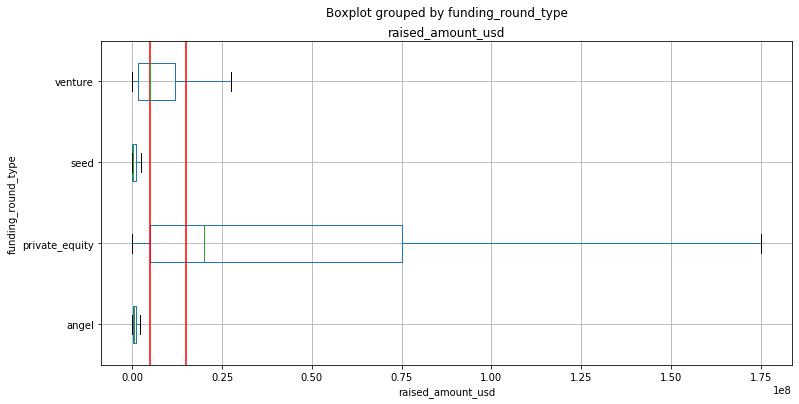

In [48]:
# A plot showing the representative amount of investment in each funding type. 
# This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.
ax = rep_funding.boxplot(column='raised_amount_usd', by='funding_round_type', 
                         showfliers=False, vert=False, figsize=(12, 6))
ax.axvline(5000000, color='r');
ax.axvline(15000000, color='r');
ax.set_xlabel('raised_amount_usd');
ax.set_ylabel('funding_round_type');

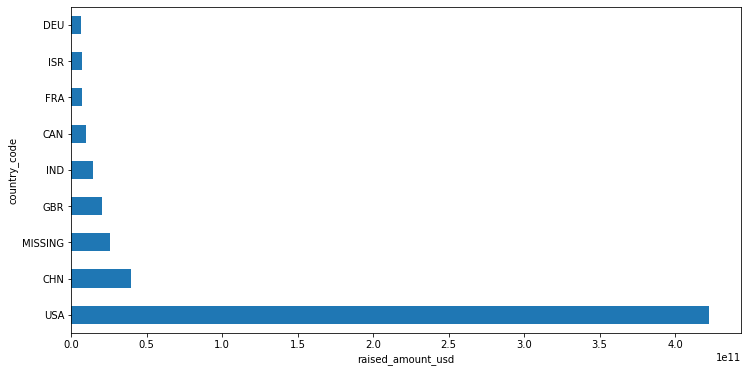

In [49]:
# A plot showing the top 9 countries against the total amount of investments of funding type FT. 
# This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.
ax = country_data.groupby('country_code')['raised_amount_usd'].agg('sum').sort_values(
    ascending=False).head(9).plot.barh(figsize=(12, 6))
ax.set_xlabel("raised_amount_usd");

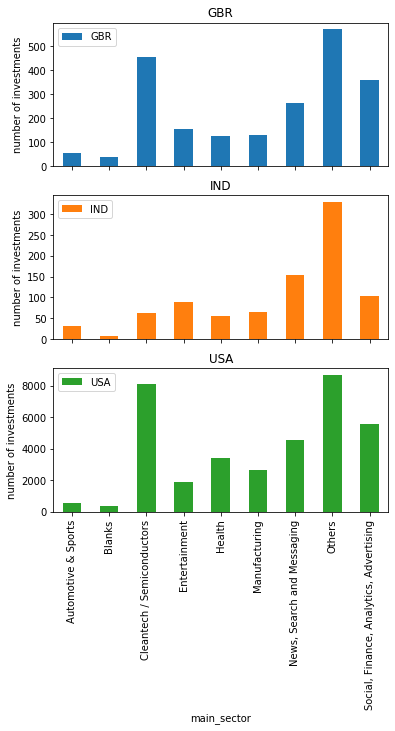

In [50]:
# A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart 
# (for the chosen investment type FT). This plot should clearly display the top 3 sectors each in 
# Country 1, Country 2, and Country 3.
axes = sector_analysis.groupby(['country_code', 'main_sector'])['funding_round_permalink'].agg(
        'count').unstack(level=0).plot.bar(subplots=True, figsize=(6, 9))
axes[0].set_ylabel('number of investments');
axes[1].set_ylabel('number of investments');
axes[2].set_ylabel('number of investments');

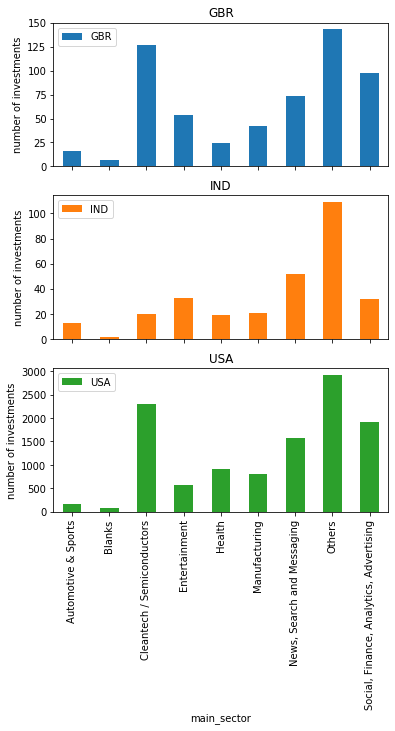

In [51]:
# Third plot within the funsing linit of 5-15M USD
# mostly same, only for IND the third sector is now Entertainment instead of Social, Finance, Analytics, Advertising
axes = sector_analysis_fund.groupby(['country_code', 'main_sector'])['funding_round_permalink'].agg(
        'count').unstack(level=0).plot.bar(subplots=True, figsize=(6, 9))
axes[0].set_ylabel('number of investments');
axes[1].set_ylabel('number of investments');
axes[2].set_ylabel('number of investments');